In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pycocotools

Mounted at /content/drive


In [2]:
!pip install -U albumentations

IMPORT AND CONFIGURATION

In [15]:

def process_dataset(source_data, image_id_offset, ann_id_offset):
    images = []
    annotations = []
    image_id_map = {}

    for img in source_data['images']:
        old_id = img['id']
        new_id = old_id + image_id_offset
        image_id_map[old_id] = new_id
        img['id'] = new_id
        images.append(img)

    for ann in source_data['annotations']:
        ann['id'] += ann_id_offset
        ann['image_id'] = image_id_map[ann['image_id']]
        annotations.append(ann)

    return images, annotations

normal_images, normal_annotations = process_dataset(normal_data, 0, 0)
merged_data['images'].extend(normal_images)
merged_data['annotations'].extend(normal_annotations)


image_id_offset = len(merged_data['images'])
ann_id_offset = len(merged_data['annotations'])


drusen_images, drusen_annotations = process_dataset(drusen_data, image_id_offset, ann_id_offset)
merged_data['images'].extend(drusen_images)
merged_data['annotations'].extend(drusen_annotations)

In [20]:
# Part 1: Imports, Setup, and Configuration
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import os
import cv2
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import json
from google.colab import drive
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2


drive.mount('/content/drive')


PROJECT_FOLDER_IN_DRIVE = '/content/drive/MyDrive/oct_major_project/'
COMBINED_DATA_DIR = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'combined_data/')
JSON_PATH = os.path.join(COMBINED_DATA_DIR, '_merged_annotations.coco.json')
IMAGE_DIR = os.path.join(COMBINED_DATA_DIR, 'images/')
MASK_SAVE_DIR = os.path.join(COMBINED_DATA_DIR, 'masks/')


os.makedirs(MASK_SAVE_DIR, exist_ok=True)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_CLASSES = 11
K_FOLDS = 5
NUM_EPOCHS_PER_FOLD = 25

print(f"Using device: {DEVICE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


GROUND TRUTH MASK GENERATION

In [21]:
print("Loading COCO JSON for segmentation...")
coco = COCO(JSON_PATH)
img_ids = coco.getImgIds()
images = coco.loadImgs(img_ids)

print(f"Found {len(images)} images. Starting mask generation...")

for img_info in tqdm(images, desc="Generating Masks"):
    img_id = img_info['id']
    img_file_name = img_info['file_name']
    img_height = img_info['height']
    img_width = img_info['width']

    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        category_id = ann['category_id']
        for seg in ann['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], color=(category_id))

    base_name = img_file_name.split('.')[0]
    mask_file_name = f"{base_name}.png"
    save_path = os.path.join(MASK_SAVE_DIR, mask_file_name)
    cv2.imwrite(save_path, mask)

print(f"\nMask generation complete! The images are saved in: {MASK_SAVE_DIR}")

Loading COCO JSON for segmentation...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 39 images. Starting mask generation...


Generating Masks: 100%|██████████| 39/39 [00:00<00:00, 146.56it/s]


Mask generation complete! The images are saved in: /content/drive/MyDrive/oct_major_project/combined_data/masks/


UNET MODEL DEFENITION

In [22]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=NUM_CLASSES, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

print("U-Net model class defined.")

U-Net model class defined.


CUSTOM DATASET CLASS

In [23]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = self.images[index]
        mask_file = img_file.split('.')[0] + '.png'

        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)


        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask



train_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.2),
        A.GaussNoise(p=0.2),


        A.Normalize(mean=[0.5], std=[0.5]),


        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=512, width=512),


        A.Normalize(mean=[0.5], std=[0.5]),


        ToTensorV2(),
    ]
)

print("Dataset class and augmentation transforms have been updated.")

Dataset class and augmentation transforms have been updated.


In [24]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader


full_dataset = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)


dice_scores = []
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

print("--- Starting 5-Fold Cross-Validation ---")

for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print(f"\n----------- FOLD {fold+1}/{K_FOLDS} -----------")


    train_subset = Subset(full_dataset, train_ids)
    val_subset = Subset(full_dataset, val_ids)


    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform


    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)


    model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()


    for epoch in range(NUM_EPOCHS_PER_FOLD):
        print(f"  Epoch {epoch+1}/{NUM_EPOCHS_PER_FOLD}")
        train_fn(train_loader, model, optimizer, loss_fn)


    print(f"--- Evaluating on Fold {fold+1} ---")
    fold_dice_score = check_accuracy(val_loader, model, device=DEVICE)
    dice_scores.append(fold_dice_score.item())


average_dice_score = sum(dice_scores) / len(dice_scores)
print("\n----------- K-Fold Cross-Validation Results -----------")
print(f"Dice scores for each fold: {dice_scores}")
print(f"Average Dice Score across all {K_FOLDS} folds: {average_dice_score:.4f}")

--- Starting 5-Fold Cross-Validation ---

----------- FOLD 1/5 -----------
  Epoch 1/25


Training:   0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: expected scalar type Long but found Byte

In [9]:
import torch

print("Calculating class weights from the training set...")


num_classes = 11
pixel_counts = torch.zeros(num_classes, dtype=torch.long)


temp_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

for _, masks in tqdm(temp_loader, desc="Counting pixels per class"):
    for i in range(num_classes):
        pixel_counts[i] += (masks == i).sum()

print("\nTotal pixels per class in the training set:")
for i in range(num_classes):
    print(f"Class {i}: {pixel_counts[i].item()} pixels")


epsilon = 1e-6
weights = 1.0 / (pixel_counts.float() + 1e-6)


weights = weights / weights.sum()


class_weights = weights.to(DEVICE)

print("\nCalculated Class Weights (normalized):")
print(class_weights)

Calculating class weights from the training set...


Counting pixels per class: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



Total pixels per class in the training set:
Class 0: 6831877 pixels
Class 1: 115550 pixels
Class 2: 149015 pixels
Class 3: 127719 pixels
Class 4: 173181 pixels
Class 5: 103865 pixels
Class 6: 231620 pixels
Class 7: 219864 pixels
Class 8: 17536 pixels
Class 9: 41622 pixels
Class 10: 114615 pixels

Calculated Class Weights (normalized):
tensor([0.0011, 0.0630, 0.0488, 0.0570, 0.0420, 0.0701, 0.0314, 0.0331, 0.4151,
        0.1749, 0.0635], device='cuda:0')


TRAINING FUNTION

In [10]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device=DEVICE), targets.to(device=DEVICE)

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Average training loss for the epoch: {total_loss / len(loader)}")

print("Training function defined.")


Training function defined.


TRAINING

In [11]:
def check_metrics(loader, model, device="cuda"):
    """
    Calculates and prints Pixel Accuracy, Dice Score, and IoU Score for a given dataset.
    """
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0


    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculating Metrics"):
            x = x.to(device)
            y = y.to(device)

            preds = model(x)
            preds = torch.argmax(preds, dim=1)


            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            y_one_hot = torch.nn.functional.one_hot(y, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            preds_one_hot = torch.nn.functional.one_hot(preds, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            intersection = (preds_one_hot * y_one_hot).float().sum()


            union = preds_one_hot.float().sum() + y_one_hot.float().sum()


            dice_score += (2. * intersection) / (union + 1e-8) # 1e-8 to avoid division by zero


            iou_score += intersection / (union - intersection + 1e-8)


    pixel_acc = (num_correct/num_pixels)*100
    avg_dice = (dice_score/len(loader))
    avg_iou = (iou_score/len(loader))

    print(f"\nGot {num_correct}/{num_pixels} with pixel accuracy {pixel_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")


    model.train()

    return pixel_acc, avg_dice, avg_iou

In [12]:

model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

print("Loss function updated with class weights.")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


from torch.utils.data import random_split, Subset


full_dataset_for_split = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)


train_size = int(0.8 * len(full_dataset_for_split))
val_size = len(full_dataset_for_split) - train_size
indices = list(range(len(full_dataset_for_split)))
train_indices, val_indices = random_split(indices, [train_size, val_size])

print(f"Full dataset size: {len(full_dataset_for_split)}")
print(f"Training indices: {len(train_indices)}")
print(f"Validation indices: {len(val_indices)}")



train_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=train_transform
)


val_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=val_transform
)



train_subset = Subset(train_dataset_with_transform, train_indices)
val_subset = Subset(val_dataset_with_transform, val_indices)


train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\nDatasets and DataLoaders created successfully with augmentations for the training set.")



for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_fn(train_loader, model, optimizer, loss_fn)
    print("\n--- VALIDATION METRICS ---")
    check_metrics(val_loader, model, device=DEVICE)

print("\nTraining finished!")

print("\n--- FINAL VALIDATION METRICS ---")
check_metrics(val_loader, model, device=DEVICE)


MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Loss function updated with class weights.
Full dataset size: 39
Training indices: 31
Validation indices: 8

Datasets and DataLoaders created successfully with augmentations for the training set.

--- Epoch 1/75 ---


Training: 100%|██████████| 8/8 [00:08<00:00,  1.06s/it, loss=2.33]


Average training loss for the epoch: 2.393266946077347

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]



Got 5494/2097152 with pixel accuracy 0.26%
Average Dice Score: 0.0026
Average IoU Score: 0.0013

--- Epoch 2/75 ---


Training: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s, loss=2.19]


Average training loss for the epoch: 2.224057585000992

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]



Got 167597/2097152 with pixel accuracy 7.99%
Average Dice Score: 0.0799
Average IoU Score: 0.0416

--- Epoch 3/75 ---


Training: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s, loss=1.87]


Average training loss for the epoch: 2.0548455119132996

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]



Got 1057754/2097152 with pixel accuracy 50.44%
Average Dice Score: 0.5044
Average IoU Score: 0.3373

--- Epoch 4/75 ---


Training: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s, loss=2.12]


Average training loss for the epoch: 1.958689123392105

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]



Got 1228704/2097152 with pixel accuracy 58.59%
Average Dice Score: 0.5859
Average IoU Score: 0.4143

--- Epoch 5/75 ---


Training: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s, loss=1.87]


Average training loss for the epoch: 1.845666229724884

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]



Got 1245282/2097152 with pixel accuracy 59.38%
Average Dice Score: 0.5938
Average IoU Score: 0.4223

--- Epoch 6/75 ---


Training: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s, loss=1.69]


Average training loss for the epoch: 1.780185729265213

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]



Got 1256414/2097152 with pixel accuracy 59.91%
Average Dice Score: 0.5991
Average IoU Score: 0.4277

--- Epoch 7/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s, loss=1.59]


Average training loss for the epoch: 1.7006809264421463

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]



Got 1298203/2097152 with pixel accuracy 61.90%
Average Dice Score: 0.6190
Average IoU Score: 0.4483

--- Epoch 8/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=1.5]


Average training loss for the epoch: 1.6037941426038742

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]



Got 1366150/2097152 with pixel accuracy 65.14%
Average Dice Score: 0.6514
Average IoU Score: 0.4831

--- Epoch 9/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.63]


Average training loss for the epoch: 1.586620643734932

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1393908/2097152 with pixel accuracy 66.47%
Average Dice Score: 0.6647
Average IoU Score: 0.4978

--- Epoch 10/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.54]


Average training loss for the epoch: 1.541634663939476

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]



Got 1417551/2097152 with pixel accuracy 67.59%
Average Dice Score: 0.6759
Average IoU Score: 0.5107

--- Epoch 11/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.34]


Average training loss for the epoch: 1.4395215958356857

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]



Got 1435211/2097152 with pixel accuracy 68.44%
Average Dice Score: 0.6844
Average IoU Score: 0.5203

--- Epoch 12/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.75]


Average training loss for the epoch: 1.4431842267513275

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]



Got 1439291/2097152 with pixel accuracy 68.63%
Average Dice Score: 0.6863
Average IoU Score: 0.5225

--- Epoch 13/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=1.44]


Average training loss for the epoch: 1.4089991301298141

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]



Got 1470003/2097152 with pixel accuracy 70.10%
Average Dice Score: 0.7010
Average IoU Score: 0.5397

--- Epoch 14/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=1.6]


Average training loss for the epoch: 1.3910447508096695

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]



Got 1492350/2097152 with pixel accuracy 71.16%
Average Dice Score: 0.7116
Average IoU Score: 0.5524

--- Epoch 15/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.34]


Average training loss for the epoch: 1.3658577352762222

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]



Got 1426974/2097152 with pixel accuracy 68.04%
Average Dice Score: 0.6804
Average IoU Score: 0.5158

--- Epoch 16/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.33]


Average training loss for the epoch: 1.3966952860355377

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]



Got 1483728/2097152 with pixel accuracy 70.75%
Average Dice Score: 0.7075
Average IoU Score: 0.5475

--- Epoch 17/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.4]


Average training loss for the epoch: 1.4118062257766724

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]



Got 1484230/2097152 with pixel accuracy 70.77%
Average Dice Score: 0.7077
Average IoU Score: 0.5481

--- Epoch 18/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=1.43]


Average training loss for the epoch: 1.4092989712953568

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]



Got 1459460/2097152 with pixel accuracy 69.59%
Average Dice Score: 0.6959
Average IoU Score: 0.5338

--- Epoch 19/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.43]


Average training loss for the epoch: 1.3398772180080414

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]



Got 1394517/2097152 with pixel accuracy 66.50%
Average Dice Score: 0.6650
Average IoU Score: 0.4982

--- Epoch 20/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.47]


Average training loss for the epoch: 1.3167850524187088

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



Got 1478522/2097152 with pixel accuracy 70.50%
Average Dice Score: 0.7050
Average IoU Score: 0.5445

--- Epoch 21/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=1.32]


Average training loss for the epoch: 1.3116579204797745

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]



Got 1482873/2097152 with pixel accuracy 70.71%
Average Dice Score: 0.7071
Average IoU Score: 0.5470

--- Epoch 22/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.39]


Average training loss for the epoch: 1.2956341952085495

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



Got 1507308/2097152 with pixel accuracy 71.87%
Average Dice Score: 0.7187
Average IoU Score: 0.5611

--- Epoch 23/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.55]


Average training loss for the epoch: 1.267999529838562

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]



Got 1546451/2097152 with pixel accuracy 73.74%
Average Dice Score: 0.7374
Average IoU Score: 0.5841

--- Epoch 24/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.32]


Average training loss for the epoch: 1.2549989372491837

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Got 1564679/2097152 with pixel accuracy 74.61%
Average Dice Score: 0.7461
Average IoU Score: 0.5950

--- Epoch 25/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.31]


Average training loss for the epoch: 1.2545161694288254

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



Got 1574004/2097152 with pixel accuracy 75.05%
Average Dice Score: 0.7505
Average IoU Score: 0.6007

--- Epoch 26/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.12]


Average training loss for the epoch: 1.219977930188179

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



Got 1589101/2097152 with pixel accuracy 75.77%
Average Dice Score: 0.7577
Average IoU Score: 0.6100

--- Epoch 27/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.06]


Average training loss for the epoch: 1.2413405627012253

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Got 1579704/2097152 with pixel accuracy 75.33%
Average Dice Score: 0.7533
Average IoU Score: 0.6043

--- Epoch 28/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.31]


Average training loss for the epoch: 1.1821171045303345

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]



Got 1588042/2097152 with pixel accuracy 75.72%
Average Dice Score: 0.7572
Average IoU Score: 0.6094

--- Epoch 29/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.34]


Average training loss for the epoch: 1.1919870898127556

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]



Got 1588118/2097152 with pixel accuracy 75.73%
Average Dice Score: 0.7573
Average IoU Score: 0.6094

--- Epoch 30/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.18]


Average training loss for the epoch: 1.1532029211521149

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]



Got 1582963/2097152 with pixel accuracy 75.48%
Average Dice Score: 0.7548
Average IoU Score: 0.6062

--- Epoch 31/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.18]


Average training loss for the epoch: 1.1693867892026901

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]



Got 1607876/2097152 with pixel accuracy 76.67%
Average Dice Score: 0.7667
Average IoU Score: 0.6217

--- Epoch 32/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.11]


Average training loss for the epoch: 1.1497627943754196

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]



Got 1611304/2097152 with pixel accuracy 76.83%
Average Dice Score: 0.7683
Average IoU Score: 0.6238

--- Epoch 33/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.06]


Average training loss for the epoch: 1.153234340250492

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]



Got 1599996/2097152 with pixel accuracy 76.29%
Average Dice Score: 0.7629
Average IoU Score: 0.6168

--- Epoch 34/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.1]


Average training loss for the epoch: 1.1434043049812317

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



Got 1526281/2097152 with pixel accuracy 72.78%
Average Dice Score: 0.7278
Average IoU Score: 0.5721

--- Epoch 35/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.18]


Average training loss for the epoch: 1.1611796617507935

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]



Got 1563007/2097152 with pixel accuracy 74.53%
Average Dice Score: 0.7453
Average IoU Score: 0.5940

--- Epoch 36/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.04]


Average training loss for the epoch: 1.1253338903188705

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]



Got 1657391/2097152 with pixel accuracy 79.03%
Average Dice Score: 0.7903
Average IoU Score: 0.6533

--- Epoch 37/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.22]


Average training loss for the epoch: 1.1435217335820198

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]



Got 1538950/2097152 with pixel accuracy 73.38%
Average Dice Score: 0.7338
Average IoU Score: 0.5796

--- Epoch 38/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.14]


Average training loss for the epoch: 1.156851515173912

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]



Got 1589094/2097152 with pixel accuracy 75.77%
Average Dice Score: 0.7577
Average IoU Score: 0.6100

--- Epoch 39/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.14]


Average training loss for the epoch: 1.1276583969593048

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]



Got 1636683/2097152 with pixel accuracy 78.04%
Average Dice Score: 0.7804
Average IoU Score: 0.6399

--- Epoch 40/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.21]


Average training loss for the epoch: 1.130620613694191

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]



Got 1659263/2097152 with pixel accuracy 79.12%
Average Dice Score: 0.7912
Average IoU Score: 0.6545

--- Epoch 41/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.13]


Average training loss for the epoch: 1.122537612915039

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]



Got 1736323/2097152 with pixel accuracy 82.79%
Average Dice Score: 0.8279
Average IoU Score: 0.7066

--- Epoch 42/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.07]


Average training loss for the epoch: 1.1421289965510368

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]



Got 1655378/2097152 with pixel accuracy 78.93%
Average Dice Score: 0.7893
Average IoU Score: 0.6520

--- Epoch 43/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.23]


Average training loss for the epoch: 1.1147308498620987

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]



Got 1643571/2097152 with pixel accuracy 78.37%
Average Dice Score: 0.7837
Average IoU Score: 0.6444

--- Epoch 44/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.16]


Average training loss for the epoch: 1.102398619055748

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]



Got 1746014/2097152 with pixel accuracy 83.26%
Average Dice Score: 0.8326
Average IoU Score: 0.7132

--- Epoch 45/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.35]


Average training loss for the epoch: 1.0845123827457428

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]



Got 1654169/2097152 with pixel accuracy 78.88%
Average Dice Score: 0.7888
Average IoU Score: 0.6512

--- Epoch 46/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.05]


Average training loss for the epoch: 1.0874194726347923

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]



Got 1782847/2097152 with pixel accuracy 85.01%
Average Dice Score: 0.8501
Average IoU Score: 0.7397

--- Epoch 47/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.11]


Average training loss for the epoch: 1.074145719408989

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]



Got 1687998/2097152 with pixel accuracy 80.49%
Average Dice Score: 0.8049
Average IoU Score: 0.6735

--- Epoch 48/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1]


Average training loss for the epoch: 1.1136960685253143

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]



Got 1766760/2097152 with pixel accuracy 84.25%
Average Dice Score: 0.8425
Average IoU Score: 0.7278

--- Epoch 49/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.983]


Average training loss for the epoch: 1.1052544191479683

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]



Got 1664916/2097152 with pixel accuracy 79.39%
Average Dice Score: 0.7939
Average IoU Score: 0.6582

--- Epoch 50/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.07]


Average training loss for the epoch: 1.0919411331415176

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]



Got 1724140/2097152 with pixel accuracy 82.21%
Average Dice Score: 0.8221
Average IoU Score: 0.6981

--- Epoch 51/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.07]


Average training loss for the epoch: 1.053803190588951

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



Got 1744541/2097152 with pixel accuracy 83.19%
Average Dice Score: 0.8319
Average IoU Score: 0.7124

--- Epoch 52/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.26]


Average training loss for the epoch: 1.066408671438694

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]



Got 1661579/2097152 with pixel accuracy 79.23%
Average Dice Score: 0.7923
Average IoU Score: 0.6562

--- Epoch 53/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.15]


Average training loss for the epoch: 1.0502355620265007

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]



Got 1810628/2097152 with pixel accuracy 86.34%
Average Dice Score: 0.8634
Average IoU Score: 0.7597

--- Epoch 54/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.24]


Average training loss for the epoch: 1.085454873740673

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]



Got 1809867/2097152 with pixel accuracy 86.30%
Average Dice Score: 0.8630
Average IoU Score: 0.7591

--- Epoch 55/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.944]


Average training loss for the epoch: 1.0740189626812935

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]



Got 1691937/2097152 with pixel accuracy 80.68%
Average Dice Score: 0.8068
Average IoU Score: 0.6763

--- Epoch 56/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.32]


Average training loss for the epoch: 1.1190437600016594

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]



Got 1719056/2097152 with pixel accuracy 81.97%
Average Dice Score: 0.8197
Average IoU Score: 0.6946

--- Epoch 57/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.17]


Average training loss for the epoch: 1.0809550136327744

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Got 1820767/2097152 with pixel accuracy 86.82%
Average Dice Score: 0.8682
Average IoU Score: 0.7676

--- Epoch 58/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.2]


Average training loss for the epoch: 1.0570430606603622

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]



Got 1796353/2097152 with pixel accuracy 85.66%
Average Dice Score: 0.8566
Average IoU Score: 0.7491

--- Epoch 59/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.12]


Average training loss for the epoch: 1.02263555675745

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]



Got 1699610/2097152 with pixel accuracy 81.04%
Average Dice Score: 0.8104
Average IoU Score: 0.6815

--- Epoch 60/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.796]


Average training loss for the epoch: 1.0027339830994606

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]



Got 1830620/2097152 with pixel accuracy 87.29%
Average Dice Score: 0.8729
Average IoU Score: 0.7745

--- Epoch 61/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.17]


Average training loss for the epoch: 1.0268101766705513

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]



Got 1776941/2097152 with pixel accuracy 84.73%
Average Dice Score: 0.8473
Average IoU Score: 0.7351

--- Epoch 62/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.951]


Average training loss for the epoch: 1.0104477554559708

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]



Got 1831501/2097152 with pixel accuracy 87.33%
Average Dice Score: 0.8733
Average IoU Score: 0.7752

--- Epoch 63/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.01]


Average training loss for the epoch: 1.0116468146443367

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



Got 1733151/2097152 with pixel accuracy 82.64%
Average Dice Score: 0.8264
Average IoU Score: 0.7042

--- Epoch 64/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=0.938]


Average training loss for the epoch: 1.0074545070528984

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]



Got 1800874/2097152 with pixel accuracy 85.87%
Average Dice Score: 0.8587
Average IoU Score: 0.7525

--- Epoch 65/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.16]


Average training loss for the epoch: 0.9995497390627861

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]



Got 1815131/2097152 with pixel accuracy 86.55%
Average Dice Score: 0.8655
Average IoU Score: 0.7633

--- Epoch 66/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.15]


Average training loss for the epoch: 1.0033270195126534

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]



Got 1844925/2097152 with pixel accuracy 87.97%
Average Dice Score: 0.8797
Average IoU Score: 0.7853

--- Epoch 67/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.28]


Average training loss for the epoch: 1.0290401801466942

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1795923/2097152 with pixel accuracy 85.64%
Average Dice Score: 0.8564
Average IoU Score: 0.7489

--- Epoch 68/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.927]


Average training loss for the epoch: 1.0071500018239021

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



Got 1785522/2097152 with pixel accuracy 85.14%
Average Dice Score: 0.8514
Average IoU Score: 0.7414

--- Epoch 69/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.2]


Average training loss for the epoch: 1.0305021703243256

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]



Got 1838515/2097152 with pixel accuracy 87.67%
Average Dice Score: 0.8767
Average IoU Score: 0.7805

--- Epoch 70/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.934]


Average training loss for the epoch: 0.9947248920798302

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]



Got 1737763/2097152 with pixel accuracy 82.86%
Average Dice Score: 0.8286
Average IoU Score: 0.7074

--- Epoch 71/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.19]


Average training loss for the epoch: 0.999599501490593

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]



Got 1744933/2097152 with pixel accuracy 83.20%
Average Dice Score: 0.8320
Average IoU Score: 0.7126

--- Epoch 72/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.22]


Average training loss for the epoch: 1.0340229496359825

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]



Got 1791471/2097152 with pixel accuracy 85.42%
Average Dice Score: 0.8542
Average IoU Score: 0.7456

--- Epoch 73/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.07]


Average training loss for the epoch: 0.981582798063755

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



Got 1755375/2097152 with pixel accuracy 83.70%
Average Dice Score: 0.8370
Average IoU Score: 0.7198

--- Epoch 74/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.922]


Average training loss for the epoch: 0.9841112568974495

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Got 1821029/2097152 with pixel accuracy 86.83%
Average Dice Score: 0.8683
Average IoU Score: 0.7680

--- Epoch 75/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=1.11]


Average training loss for the epoch: 1.0706285312771797

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



Got 1735665/2097152 with pixel accuracy 82.76%
Average Dice Score: 0.8276
Average IoU Score: 0.7060

Training finished!

--- FINAL VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]



Got 1735665/2097152 with pixel accuracy 82.76%
Average Dice Score: 0.8276
Average IoU Score: 0.7060
Model saved to /content/drive/MyDrive/oct_major_project/unet_retina_segmentation.pth


TEST

In [13]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
model = UNet(in_channels=1, out_channels=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")


uploaded_image_path = '/content/Normal-macular-OCT-1.png'


predict_on_single_image(model, uploaded_image_path, DEVICE)

Model loaded and ready for prediction.
Error: Could not load image at /content/Normal-macular-OCT-1.png


Model loaded and ready for prediction.
Original image shape: (512, 512)
Resized to: (512, 512)


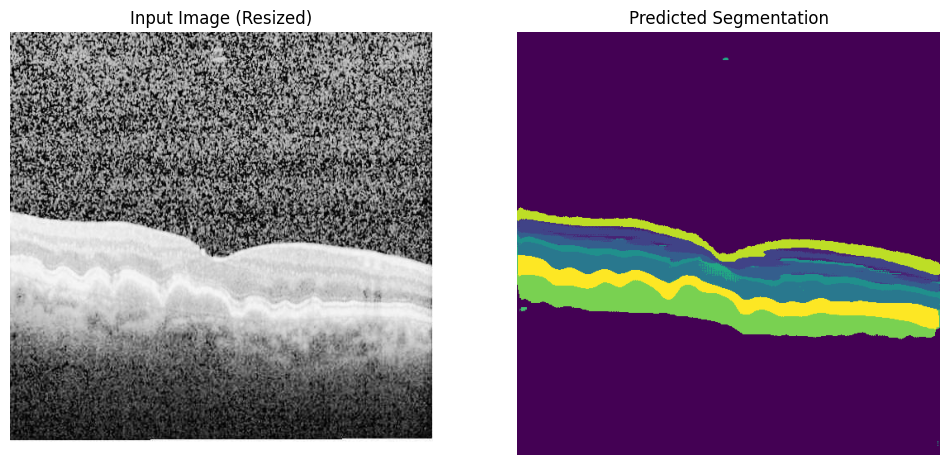

In [14]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
model = UNet(in_channels=1, out_channels=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")



uploaded_image_path = '/content/drive/MyDrive/oct_major_project/drusen 2.v1i.coco-segmentation/train/DRUSEN-8023853-102_jpeg.rf.0fcea15b0f8b2e94c8f915e3edea504d.jpg'


predict_on_single_image(model, uploaded_image_path, DEVICE)